In [5]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [7]:
# Считывание файла csv для анализа
mobile_app = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-o-demchenko-18/statistic/Lesson10/hw_aa.csv', sep=';', index_col=0)

In [8]:
mobile_app

,uid,experimentVariant,version,purchase
1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0
...,...,...,...,...
127014,d1f082ede77b17a99a9b0b240daf7bdf,0,v2.8.0,0
127015,94f0d540830ccdc6b29c1938eea445cc,0,v2.8.0,0
127016,709f74cf9721328e98be6f216e8a05a8,1,v2.9.0,0
127017,1767ae3f8ffec269d9ed0ac0ede68d90,1,v2.8.0,0


In [3]:
# Проверка кол-ва уникальных значений
mobile_app.nunique()

uid                  127018
experimentVariant         2
version                   4
purchase                  2
dtype: int64

In [4]:
# Просмотр основной информации о датафрейме
mobile_app.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127018 entries, 1 to 127018
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   uid                127018 non-null  object
 1   experimentVariant  127018 non-null  int64 
 2   version            127018 non-null  object
 3   purchase           127018 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 4.8+ MB


In [5]:
# Пропущенных значений нет, проверим на дубликаты
any(mobile_app['uid'].duplicated())

False

In [6]:
mobile_app.shape

(127018, 4)

## A/A-тест

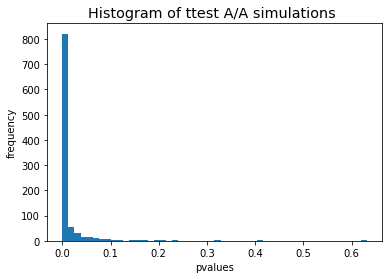

0.922

In [9]:
n = 130000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = mobile_app[mobile_app.experimentVariant == 1]['purchase'].sample(n_s, replace = False).values
    s2 = mobile_app[mobile_app.experimentVariant == 0]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

Значения FPR значительно выше уровня альфа(>90%). Попробуем найти ошибку в системе сплитования.

In [41]:
# Сгруппируем по экспериментальной группе, версии приложения и посчитаем конверсию для каждой группы и число пользователей в гр.
mobile_app.groupby(['experimentVariant', 'version'], as_index=False).agg({'purchase': 'mean', 'uid': 'count'})

,experimentVariant,version,purchase,uid
0,0,v2.8.0,0.000993,41283
1,0,v2.9.0,0.074658,11921
2,0,v3.7.4.0,0.059943,4204
3,0,v3.8.0.0,0.057604,5694
4,1,v2.8.0,0.045606,41552
5,1,v2.9.0,0.071304,12033
6,1,v3.7.4.0,0.063018,4221
7,1,v3.8.0.0,0.062848,6110


Из полученных данных можем наблюдать сильные различия конверсии покупок в группах для версии приложения v2.8.0.
Для группы 0 конверсия покупок составляет менее 1%, для группы 1 уже порядка 4,5 %. В остальных группах различия не так сильно выражены.
На первый взгляд есть ошибки в версии приложения v2.8.0. 
Попробуем провести A/A тест для каждой версии приложения для наиболее точного анализа полученных результатов.

### А/A тест для версии приложения v2.8.0

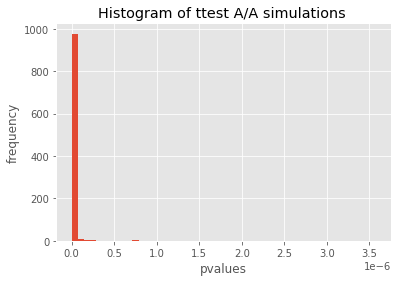

1.0

In [11]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = mobile_app[(mobile_app.experimentVariant == 1) & (mobile_app.version == 'v2.8.0')]['purchase'].sample(n_s, replace = False).values
    s2 = mobile_app[(mobile_app.experimentVariant == 0) & (mobile_app.version == 'v2.8.0')]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

### А/A тест для версии приложения v2.9.0

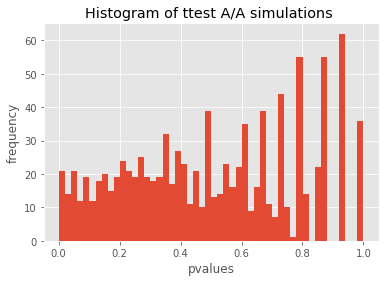

0.042

In [12]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = mobile_app[(mobile_app.experimentVariant == 1) & (mobile_app.version == 'v2.9.0')]['purchase'].sample(n_s, replace = False).values
    s2 = mobile_app[(mobile_app.experimentVariant == 0) & (mobile_app.version == 'v2.9.0')]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

### А/A тест для версии приложения v3.7.4.0

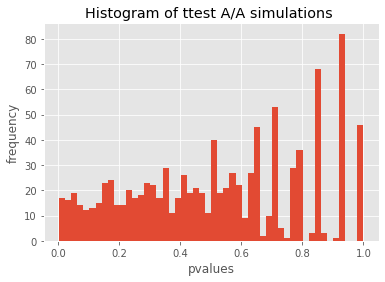

0.038

In [13]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = mobile_app[(mobile_app.experimentVariant == 1) & (mobile_app.version == 'v3.7.4.0')]['purchase'].sample(n_s, replace = False).values
    s2 = mobile_app[(mobile_app.experimentVariant == 0) & (mobile_app.version == 'v3.7.4.0')]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

### А/A тест для версии приложения v3.8.0.0

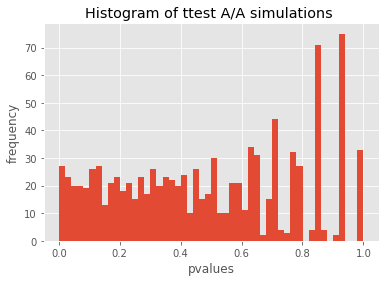

0.06

In [14]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = mobile_app[(mobile_app.experimentVariant == 1) & (mobile_app.version == 'v3.8.0.0')]['purchase'].sample(n_s, replace = False).values
    s2 = mobile_app[(mobile_app.experimentVariant == 0) & (mobile_app.version == 'v3.8.0.0')]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

## Вывод:
Значения FPR для версии приложения:
- v2.8.0 около 100% 
- v2.9.0 около 4%
- v3.7.4.0 около 4%
- v3.8.0.0 около 6%

Рассмотрим рассчет FPR без версии приложения v2.8.0, которое показало наихудшие результаты.

### А/A тест без версии приложения v2.8.0

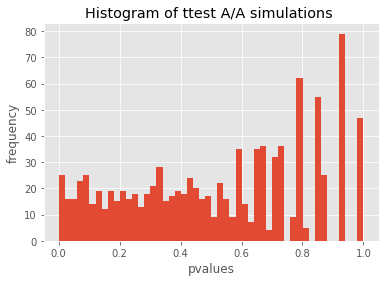

0.048

In [20]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = mobile_app[(mobile_app.experimentVariant == 1) & (mobile_app.version != 'v2.8.0')]['purchase'].sample(n_s, replace = False).values
    s2 = mobile_app[(mobile_app.experimentVariant == 0) & (mobile_app.version != 'v2.8.0')]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

## ИТОГ: Однозначно ошибка в версии приложения v2.8.0. Данную версию необходимо изучить в дальнейшем более подробно

In [ ]:
# Дополнительно проведем Т-тесты для каждой из версий МП

In [16]:
a = mobile_app[(mobile_app.experimentVariant == 1) & (mobile_app.version != 'v2.8.0')]['purchase']
b = mobile_app[(mobile_app.experimentVariant == 0) & (mobile_app.version != 'v2.8.0')]['purchase']
ss.ttest_ind(a,b)

Ttest_indResult(statistic=0.024027679164509035, pvalue=0.9808306388094195)

In [15]:
a = mobile_app[(mobile_app.experimentVariant == 1) & (mobile_app.version != 'v2.9.0')]['purchase']
b = mobile_app[(mobile_app.experimentVariant == 0) & (mobile_app.version != 'v2.9.0')]['purchase']
ss.ttest_ind(a,b)

Ttest_indResult(statistic=34.54098817253235, pvalue=6.0232305184095556e-260)

In [12]:
a = mobile_app[(mobile_app.experimentVariant == 1) & (mobile_app.version != 'v3.7.4.0')]['purchase']
b = mobile_app[(mobile_app.experimentVariant == 0) & (mobile_app.version != 'v3.7.4.0')]['purchase']
ss.ttest_ind(a,b)

Ttest_indResult(statistic=28.508336145216287, pvalue=3.7055746801446784e-178)

In [14]:
a = mobile_app[(mobile_app.experimentVariant == 1) & (mobile_app.version != 'v3.8.0.0')]['purchase']
b = mobile_app[(mobile_app.experimentVariant == 0) & (mobile_app.version != 'v3.8.0.0')]['purchase']
ss.ttest_ind(a,b)

Ttest_indResult(statistic=28.728564989994197, pvalue=7.333210030122562e-181)

Статистически значимые различия есть только у версии v2.8.0